# Hypothesis Testing with Insurance Data (Core)- Amber Kutscher
- Data Enrichment


In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import levene, kruskal

In [2]:
# Read in the data
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(url)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
# Check value counts to get the length of the dataframe
df.value_counts()

age  sex     bmi     children  smoker  region     charges    
19   male    30.590  0         no      northwest  1639.56310     2
47   male    29.830  3         no      northwest  9620.33070     1
48   female  25.850  3         yes     southeast  24180.93350    1
             22.800  0         no      southwest  8269.04400     1
47   male    47.520  1         no      southeast  8083.91980     1
                                                                ..
31   female  25.740  0         no      southeast  3756.62160     1
             23.600  2         no      southwest  4931.64700     1
             21.755  0         no      northwest  4134.08245     1
30   male    44.220  2         no      southeast  4266.16580     1
64   male    40.480  0         no      southeast  13831.11520    1
Length: 1337, dtype: int64

## Q1. Do smokers have higher insurance charges than non-smokers?


- Null Hypothesis: There is no significant difference between the insurance charges of smokers and non-smokers.
- Alternative Hypothesis: There is a significant difference between the insurance charges of smokers and non-smokers.

In [4]:
# Create sample data for testing (there are 1338 rows in the dataframe)
sample = df.sample(n=1338, random_state=42)
smoker_df = sample.loc[sample['smoker'] == 'yes'].copy()
non_smoker_df = sample.loc[sample['smoker'] == 'no'].copy()

In [5]:
# Define our feature of interest (charges) and get the mean of each group
smoker_charges = smoker_df['charges']
non_smoker_charges = non_smoker_df['charges']
print(f"For smokers (n={len(smoker_charges)}): Mean={np.mean(smoker_charges):.2f}")
print(f"For non-smokers (n={len(non_smoker_charges)}): Mean={np.mean(non_smoker_charges):.2f}")

For smokers (n=274): Mean=32050.23
For non-smokers (n=1064): Mean=8434.27


### Testing for Outliers

In [6]:
# Check for ourliers with smoker status
zscores_s = stats.zscore(smoker_charges)
outliers_s = abs(zscores_s)>3
np.sum(outliers_s)

0

In [7]:
# Check for outliers with non-smoker status
zscores_ns = stats.zscore(non_smoker_charges)
outliers_ns = abs(zscores_ns)>3
np.sum(outliers_ns)

24

- There are no outliers in the smoker group, however there are 24 outliers in the non-smoker group. Therefore, we need to remove the outliers from the dataframe.

In [8]:
# Remove outlier for no strength group
non_smoker_charges = non_smoker_charges[(np.abs(stats.zscore(non_smoker_charges)) < 3)]

### Testing Each Group for Normality

In [10]:
# Normal test smokers
result_smoker = stats.normaltest(smoker_charges)
result_smoker

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [11]:
# Normal test non-smokers
result_non_smoker = stats.normaltest(non_smoker_charges)
result_non_smoker

NormaltestResult(statistic=163.803670477892, pvalue=2.6945416315543585e-36)

- For both the smoker and non-smoker groups, the p-value is less than 0.05, so we can assume these are NOT normally distributed.

### Testing for Equal Variance

In [12]:
# Calculate overall results with levene
result = stats.levene(smoker_charges, non_smoker_charges)
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

- Since our p-value was less than .05, we reject the null hypothesis that the samples come from populations with equal variances. Therefore, we would need to include "equal_var = False" when we perform our t-test.

### Perform and Evaluate T-Test

In [13]:
# Final t-test, after confirming we meet the assumptions
result = stats.ttest_ind(smoker_charges, non_smoker_charges, equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

In [14]:
# Is our result significant?
print(f"p-value={result.pvalue:.10f}")
print(f"Significant: {result.pvalue <.05}")

p-value=0.0000000000
Significant: True


- Based on our t-test, we have a significant result. This indicates that there IS a difference between smoker and non-smoker insurances charges.

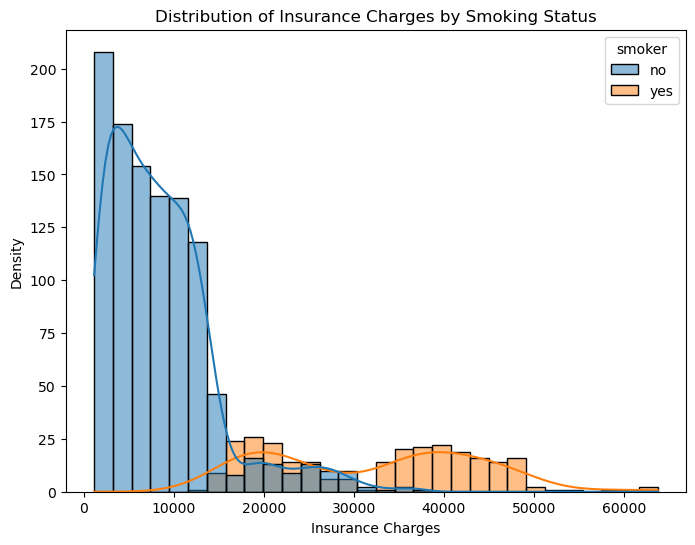

In [15]:
# Visualize the data
plt.figure(figsize=(8, 6))
sns.histplot(data=sample, x='charges', hue='smoker', kde=True)
plt.xlabel('Insurance Charges')
plt.ylabel('Density')
plt.title('Distribution of Insurance Charges by Smoking Status')
plt.show()

### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is less than 0.05, I reject the null hypothesis that there is no significant difference between the insurance charges of smokers and non-smokers. This indicates that we accept the alternative hypothesis and conclude that there is a significant difference between insurance charges of smokers vs. non-smokers.


## Q2. Are men more likely to smoke than women?


- Null Hypothesis: There is no significant difference showing that men are more likely to smoke than women.
- Alternative Hypothesis: There is a significant difference showing that men are more likely to smoke than women.

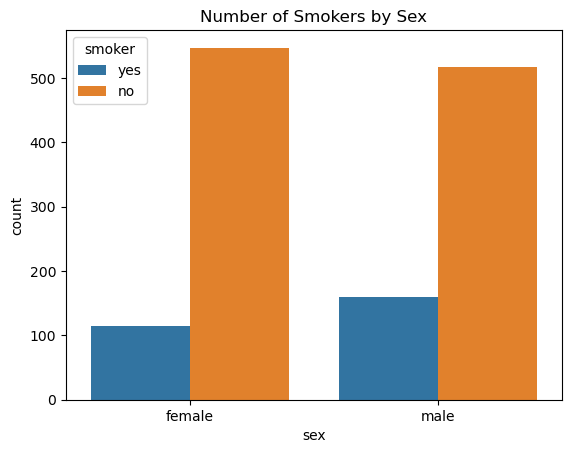

In [16]:
# Start by visualizing the data
ax = sns.countplot(data=df, x='sex', hue='smoker')
ax.set_title("Number of Smokers by Sex");

### Getting the Contingency Table

In [17]:
# Calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table

smoker,no,yes
sex,,
female,547,115
male,517,159


In [18]:
# Using Chi-Square test, run the test and save the output
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

In [19]:
# What was our p-value?
print(p)
p<.05

0.006548143503580696


True

- The p-value is much less than 0.05, so we have a significant result.

### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is less than 0.05, I reject the null hypothesis that there is no significant difference showing that men are more likely to smoke than women. This indicates that we accept the alternative hypothesis and conclude that men are more likely to smoke than women.

## Q3. Do different regions have different charges, on average?



- Null Hypothesis: There is no significant difference showing that the region affects how much someone pays for insurance.
- Alternative Hypothesis: There is a significant difference showing that the region affects how much someone pays for insurance.

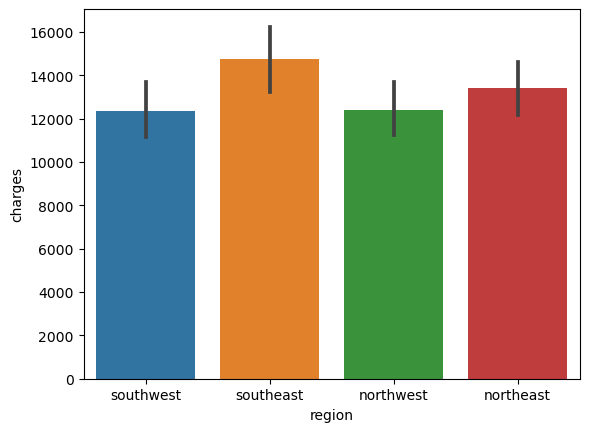

In [20]:
# Start by visualizing the data
sns.barplot(data=df, x='region', y='charges');

In [21]:
# Create groups dictionary
groups = {}

# Loop through all unique categories
for i in df['region'].unique():
    # Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    # Save into the dictionary
    groups[i] = data
groups.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

### Testing for Outliers

In [22]:
# Create a copy of the original dataframe
df_cleaned = df.copy()

# Create outliers dictionary
outlier_counts = {}

In [23]:
# # Loop through all unique categories
for region in df_cleaned['region'].unique():
    # Get series for group and rename
    data = df_cleaned.loc[df_cleaned['region'] == region, 'charges'].copy()
    # Calculate z-scores for the 'charges' column within each region
    z_scores = np.abs(stats.zscore(data))
    # Define a threshold for identifying outliers
    threshold = 3
    # Find the indices of outliers
    outlier_indices = np.where(z_scores > threshold)
    # Remove outliers from the copy of the dataframe
    df_cleaned.drop(df_cleaned.index[outlier_indices], inplace=True)
    # Save the number of outliers for this region in the dictionary
    outlier_counts[region] = len(outlier_indices[0])
# DIsplay the number of outliers for each region
for region, count in outlier_counts.items():
    print(f"Region: {region}, Number of Outliers Removed: {count}")

Region: southwest, Number of Outliers Removed: 8
Region: southeast, Number of Outliers Removed: 2
Region: northwest, Number of Outliers Removed: 7
Region: northeast, Number of Outliers Removed: 4


- Outliers were identified in each region and removed successfully.

### Testing Each Group for Normality

In [24]:
# Create a dictionary to store the normality test results
norm_results = {}

# Loop through all unique categories (regions)
for region in df_cleaned['region'].unique():
    # Check if the group has more than 20 data points (use "data" from outliers loop)
    if len(data) > 20:
        # Perform  normality test
        stat, p = stats.normaltest(data)
        # Save the p-val, test statistic, and size of the group
        norm_results[region] = {'n': len(data),
                                'p': p,
                                'test stat': stat}
# Convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,320.0,4.175033e-19,84.639989
southeast,320.0,4.175033e-19,84.639989
northwest,320.0,4.175033e-19,84.639989
northeast,320.0,4.175033e-19,84.639989


- Since n >= 15, we should ignore the assumption of normality and test the assumption for equal variance.

### Testing for Equal Variance

In [25]:
# Create a list to store the 'charges' data for each region
data_by_region = []
# Loop through all unique regions
for region in df_cleaned['region'].unique():
    # Get 'charges' data for the current region
    data =df_cleaned.loc[df_cleaned['region'] == region, 'charges']
    # Append the data to the list
    data_by_region.append(data)
# Perform the Levene test to compare variences across regions
levene_statistics, levene_pvalue = levene(*data_by_region)

# Display the Levene test results
print(f"Levene Test Statistics: {levene_statistics}")
print(f"Levene Test p_value: {levene_pvalue}")

Levene Test Statistics: 5.082473587906683
Levene Test p_value: 0.001680673999281497


In [26]:
# Interpret the results based on the p-value
if levene_pvalue < 0.05:
    print("The variances across regions are significantly different.")
else:
    print("There is no significant difference in variances across regions.")

The variances across regions are significantly different.


### Non-Parametric Testing - Kruskal-Wallis

In [27]:
# Perform the Kruskal-Wallis test to compare distributions across regions
kruskal_statistics, kruskal_pvalue = kruskal(*data_by_region)

# Display tqhe Kruskal-Wallis test results
print(f"Kruskal-Wallis Test Statistics: {kruskal_statistics}")
print(f"Kruskal-Wallis Test p-value: {kruskal_pvalue}")

Kruskal-Wallis Test Statistics: 4.41904331310216
Kruskal-Wallis Test p-value: 0.2196261124611108


In [28]:
# Interpret the results based on the p-value (small p-value indicates significant differences)
if kruskal_pvalue < 0.05:
    print("There are significant differences in 'charges' across regions.")
else:
    print("There are no significant differences in 'charges' across regions.")

There are no significant differences in 'charges' across regions.


### Interpret your p-value and reject or fail to reject your null hypothesis.
- Since our p-value is greater than 0.05, I fail to reject the null hypothesis. This indicates that there is no significant difference showing that the region affects how much someone pays for insurance.